# Business Problem

Don't f\*ck this up.<br>

That's the pitching philosophy of Jonathan Bales, as written in his book, "Fantasy Baseball for Smart People."<br> 

His point is that pitching is the easy part in daily fantasy baseball. Pay up for pitching because pitching is the most consistent source of points.<br>

Hitting? That's another story.<br>

Taking the final day of the 2021 regular season as an example, the maximum price for a pitcher on FanDuel was 11500 dollars. On DraftKings it was 12400. FanDuel's salary cap is 35000. On DraftKings, it's 50000.<br>

If you pay 9000 for a pitcher on FanDuel, which isn't even close to the maximum on most days, you're left with an average of 3250 for the hitters in your lineup. The highest-priced hitter on FanDuel on the last day of the 2021 regular season was 4400. Very often the max price is closer to 5000.<br>

In daily fantasy sports (DFS), cash games refer to head-to-head competitions or games in which the object is to double or multiply your entry fee by finishing "in the money." Every winner is awarded the same prize. In tournaments, or guaranteed prize pools (GPPs), you're going for the big prize, which could be as high as a million dollars. It's not winner-take-all, but the prize amounts drop off significantly. This requires more risk as you need to roster a high-scoring player that very few other players roster in order to differentiate your lineup.<br>

Now that we've defined cash games and GPPs, back to lineup construction.<br>

Even if you used the cheapest pitcher on FanDuel (5500), which is risky enough in tournaments and foolish in cash games, you're left with an average of 3687 for your eight hitters. So you if draft an elite hitter, you're forced to make wise buying decisions with the rest of your lineup. You might even need a min-priced hitter (2000 on both sites) to stay under the salary cap. And as we'll soon see, there's a very real possibility that even your 4400 hitter will score 0 points and destroy your lineup.<br>

Our model will predict scoring for hitters on FanDuel and DraftKings so that on any given day we'll have a points projection and know which high-priced hitters will be worth their salary and which hitters will be bargains.<br>

# First, a quick look at pitching
Before we dive into hitting, let's take a look at distribution of pitching points. Using FanGraphs, we're tallying FanDuel points for starting pitchers on May 1, June 2, July 4 and Aug. 1. It's a total of 110 pitchers. Since we're building a hitting model and not a pitching model, we won't explain each cell. This is just a demonstration. The point is the histogram at the end.

In [767]:
import pandas as pd
import datetime
import numpy as np

In [768]:
pitching_df_names = ['FGSP_050121', 'FGSP_060221', 'FGSP_070421', 'FGSP_080121']

In [769]:
list_of_SP_dfs = []

In [770]:
for i in range(4):
    new_SP_df = pd.read_csv(pitching_df_names[i] + ".csv")
    list_of_SP_dfs.append(new_SP_df)

In [771]:
pitching_df = pd.concat(list_of_SP_dfs)

In [772]:
pitching_df.head()

,Name,Team,W,L,ERA,G,GS,CG,ShO,SV,...,R,ER,HR,BB,IBB,HBP,WP,BK,SO,playerid
0,Jose Urquidy,HOU,1,0,0.00,1,1,0,0,0,...,0,0,0,1,0,0,0,0,5,18413
1,Travis Bergen,TOR,0,0,0.00,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,18581
2,Griffin Canning,LAA,1,0,0.00,1,1,0,0,0,...,1,0,0,2,0,0,0,0,9,19867
3,Danny Duffy,KCR,1,0,1.29,1,1,0,0,0,...,1,1,1,3,0,0,0,0,7,3542
4,Jameson Taillon,NYY,1,0,1.80,1,1,0,0,0,...,1,1,1,3,0,0,0,0,8,11674


In [773]:
len(pitching_df)

110

In [774]:
len(pitching_df['Name'].unique())

92

In [775]:
pitching_df = pitching_df[['Name', 'W', 'IP', 'ER', 'SO']]

In [776]:
pitching_df.head()

,Name,W,IP,ER,SO
0,Jose Urquidy,1,7.0,0,5
1,Travis Bergen,0,1.0,0,0
2,Griffin Canning,1,5.1,0,9
3,Danny Duffy,1,7.0,1,7
4,Jameson Taillon,1,5.0,1,8


In [777]:
pitching_df['QS'] = np.where((pitching_df['IP'] >= 6)  & (pitching_df['ER'] <= 3), 4, 0)

In [778]:
pitching_df.head()

,Name,W,IP,ER,SO,QS
0,Jose Urquidy,1,7.0,0,5,4
1,Travis Bergen,0,1.0,0,0,0
2,Griffin Canning,1,5.1,0,9,0
3,Danny Duffy,1,7.0,1,7,4
4,Jameson Taillon,1,5.0,1,8,0


In [779]:
pitching_df['IP2'] = pitching_df['IP'] % 1

In [780]:
pitching_df['IP2'] = pitching_df['IP2'] * 10

In [781]:
pitching_df['IP'] = pitching_df['IP'].round()

In [782]:
pitching_df['IP2'].unique()

array([0., 1., 2., 2., 1., 2.])

In [783]:
pitching_df['FD_Pts'] = (pitching_df['W'] * 6) + (pitching_df['IP'] * 3) + pitching_df['IP2'] \
+ (pitching_df['SO'] * 3) - (pitching_df['ER'] * 3)

In [784]:
pitching_df.head()

,Name,W,IP,ER,SO,QS,IP2,FD_Pts
0,Jose Urquidy,1,7.0,0,5,4,0.0,42.0
1,Travis Bergen,0,1.0,0,0,0,0.0,3.0
2,Griffin Canning,1,5.0,0,9,0,1.0,49.0
3,Danny Duffy,1,7.0,1,7,4,0.0,45.0
4,Jameson Taillon,1,5.0,1,8,0,0.0,42.0


In [785]:
import matplotlib.pyplot as plt

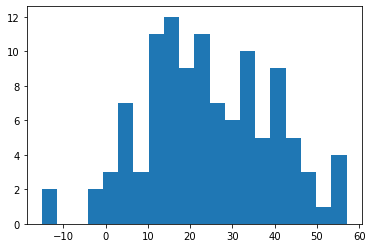

In [786]:
plt.hist(pitching_df['FD_Pts'], bins = 20);

If anything, this histogram is left-tailed, which is what you want. Look how heavy it is on the right side. All but 13 of the 110 pitching performances we're looking at scored at least 10 points, and 20, 30 and 40 points are not uncommon. It's not that easy to get 20 or 30 points out of a hitter, not without the model we're about to build.

# Target variable
Each of our observations will look at a player's performance in an individual game, and also his predictive hitting statistics for the previous 30 days. We'll also include whether he's a right-handed or left-handed hitter, if he's facing a right-handed or left-handed starting pitcher, how many runs his team is expected to score in that game and the ballpark in which he is playing.<br>

So our target variable is two-pronged (if this is allowable): FanDuel points and DraftKings points. We want to keep them separate and not average them, as we may discover that some features are more predictive of points on one site than another.<br>

If dual target variables are not an option, we'll go with FanDuel points.<br>

# Breaking ground
OK, so this for loop is doing a lot because we're pouring a lot into it.<br>

We customized 60 separate reports on FanGraphs, 30 for in-game performances and 30 for our predictive hitting features in the 30 days before each of these games (glossary at end of notebook). We're observing full slates of Major League Baseball games, each four days apart, from May 1 to Aug. 29. We're spacing them out by four days to differentiate the features. For example, a player's barrel percentage for the last 30 days could be 15.4 on May 1, 15.3 on May 2 and then maybe 15.6 on May 3. Also, a four-day gap ensures that we're seeing a larger cross-section of starting pitchers. Since starting pitchers typically go every fifth day, we'd risk our observed hitters going against many of the same pitchers if we spaced games out by five days.<br>

We're changing 'PA' (plate appearances) to 'PA_Game' for the live game-performance feature, since we already have PA for last-30 features.<br>

In [787]:
list_of_dfs = []
date_of_games = pd.to_datetime('20210427', format = '%Y%m%d')
for i in range(121, 245, 4):
    date_of_games = date_of_games + datetime.timedelta(days = 4)
    if i == 193:
        continue
    L30_df = pd.read_csv("FGBattersL30_" + str(i) + ".csv")
    L30_df.drop(columns = ['Team', 'playerid'], inplace = True)
    games_df = pd.read_csv("FGBattersFP_" + str(i) + ".csv")
    games_df = games_df[games_df['PA'] > 0]
    games_df.rename(columns = {'PA':'PA_Game'}, inplace = True)
    new_df = pd.merge(games_df, L30_df, how = 'left', on = 'Name')
    new_df.insert(0, 'Date', date_of_games)
    list_of_dfs.append(new_df)

In [788]:
main_df = pd.concat(list_of_dfs, ignore_index = True)

In [789]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+
0,2021-05-01,Jurickson Profar,SDP,1,0,0,0,1,1,1,...,45.9%,61.0%,8.1%,20.8%,51.4%,27.8%,36.1%,31.9%,31.9%,86.0
1,2021-05-01,Justin Williams,STL,1,0,0,0,1,2,1,...,37.9%,53.9%,13.6%,13.2%,50.0%,36.8%,28.9%,47.4%,23.7%,47.0
2,2021-05-01,Andy Young,ARI,1,0,0,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,37.9%,46.2%,9.5%,31.3%,39.1%,29.7%,43.8%,35.9%,20.3%,155.0
4,2021-05-01,David Peralta,ARI,1,0,1,0,0,0,0,...,43.8%,51.9%,8.9%,13.4%,52.4%,34.1%,31.7%,41.5%,26.8%,118.0


In [790]:
main_df.tail()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+
8426,2021-08-29,Lars Nootbaar,STL,1,0,0,0,0,0,0,...,43.1%,59.2%,6.1%,15.2%,57.6%,27.3%,33.3%,39.4%,27.3%,173.0
8427,2021-08-29,Cal Raleigh,SEA,3,0,0,0,0,0,0,...,45.8%,72.7%,21.1%,20.5%,66.7%,12.8%,43.6%,30.8%,25.6%,37.0
8428,2021-08-29,Ryan Jeffers,MIN,4,0,0,0,0,0,0,...,37.6%,59.7%,13.1%,20.6%,38.2%,41.2%,44.1%,44.1%,11.8%,130.0
8429,2021-08-29,Sam Long,SFG,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8430,2021-08-29,Kwang-hyun Kim,STL,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [791]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8431 entries, 0 to 8430
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        8431 non-null   datetime64[ns]
 1   Name        8431 non-null   object        
 2   Team        8431 non-null   object        
 3   PA_Game     8431 non-null   int64         
 4   1B          8431 non-null   int64         
 5   2B          8431 non-null   int64         
 6   3B          8431 non-null   int64         
 7   HR          8431 non-null   int64         
 8   RBI         8431 non-null   int64         
 9   R           8431 non-null   int64         
 10  BB          8431 non-null   int64         
 11  SB          8431 non-null   int64         
 12  HBP         8431 non-null   int64         
 13  playerid    8431 non-null   int64         
 14  PA          6943 non-null   float64       
 15  Events      6943 non-null   float64       
 16  EV          6943 non-nul

In [792]:
main_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PA_Game,8431.0,3.596845,1.365334,1.000,3.000,4.000,4.000,9.000
1B,8431.0,0.500297,0.689331,0.000,0.000,0.000,1.000,4.000
2B,8431.0,0.154786,0.395857,0.000,0.000,0.000,0.000,3.000
3B,8431.0,0.011505,0.107756,0.000,0.000,0.000,0.000,2.000
HR,8431.0,0.116000,0.345545,0.000,0.000,0.000,0.000,3.000
RBI,8431.0,0.416321,0.828232,0.000,0.000,0.000,1.000,7.000
R,8431.0,0.435891,0.674137,0.000,0.000,0.000,1.000,5.000
BB,8431.0,0.312181,0.564714,0.000,0.000,0.000,1.000,4.000
SB,8431.0,0.039972,0.207662,0.000,0.000,0.000,0.000,3.000
HBP,8431.0,0.043530,0.209791,0.000,0.000,0.000,0.000,2.000


# Dropping nulls
When we created our CSVs in FanGraphs, we set a PA minimum of 30 for the previous 30 days. That means a player needed at least 30 plate appearances in the previous 30 days to appear in our report. Otherwise the sample size would be too small. So we are dropping rows in which a player played on that day, but did not appear at the plate 30 times in the previous 30 days.

In [793]:
main_df.dropna(inplace=True)
main_df.reset_index(drop=True, inplace = True)

In [794]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6943 entries, 0 to 6942
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        6943 non-null   datetime64[ns]
 1   Name        6943 non-null   object        
 2   Team        6943 non-null   object        
 3   PA_Game     6943 non-null   int64         
 4   1B          6943 non-null   int64         
 5   2B          6943 non-null   int64         
 6   3B          6943 non-null   int64         
 7   HR          6943 non-null   int64         
 8   RBI         6943 non-null   int64         
 9   R           6943 non-null   int64         
 10  BB          6943 non-null   int64         
 11  SB          6943 non-null   int64         
 12  HBP         6943 non-null   int64         
 13  playerid    6943 non-null   int64         
 14  PA          6943 non-null   float64       
 15  Events      6943 non-null   float64       
 16  EV          6943 non-nul

# No double dipping
Some of the observed games are doubleheaders. FanDuel and DraftKings usually only put one game of a doubleheader on a slate, so you can only get points for what a player does in one game. But Pandas doesn't know that. We could have some high-scoring games that are due to a guy playing two games in one day. So let's drop all doubleheaders. This dictionary has the date of the game as the key and a list of all the teams that played doubleheaders on that day as the value.<br>

The for loop uses the dict in the following cell, and then we just test on a couple of those days to make sure it works.

In [795]:
doubleheader_dict = {'20210505': ['NYM', 'STL'], '20210529': ['COL', 'PIT', 'MIL', 'WSN', 'BAL', 'CHW'], \
                     '20210626': ['HOU', 'DET'], '20210630': ['DET', 'CLE'], '20210704': ['NYY', 'NYM'], \
                     '20210716': ['MIA', 'PHI'], '20210728': ['TOR', 'BOS'], '20210817': ['BOS', 'NYY'], \
                    '20210825': ['COL', 'CHC'], }

In [796]:
for key, value in doubleheader_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Team'].isin(value))), :]

In [797]:
main_df[(main_df['Date'] == '2021-07-28') & (main_df['Team'].isin(['TOR', 'BOS']))].head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+


In [798]:
main_df[(main_df['Date'] == '2021-06-30') & (main_df['Team'].isin(['DET', 'CLE']))].head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+


In [799]:
main_df.reset_index(drop=True, inplace=True)

In [800]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6723 entries, 0 to 6722
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        6723 non-null   datetime64[ns]
 1   Name        6723 non-null   object        
 2   Team        6723 non-null   object        
 3   PA_Game     6723 non-null   int64         
 4   1B          6723 non-null   int64         
 5   2B          6723 non-null   int64         
 6   3B          6723 non-null   int64         
 7   HR          6723 non-null   int64         
 8   RBI         6723 non-null   int64         
 9   R           6723 non-null   int64         
 10  BB          6723 non-null   int64         
 11  SB          6723 non-null   int64         
 12  HBP         6723 non-null   int64         
 13  playerid    6723 non-null   int64         
 14  PA          6723 non-null   float64       
 15  Events      6723 non-null   float64       
 16  EV          6723 non-nul

# Full games only
We're going to prune more rows by only including players who appeared at the plate at least three times in their observed game. Most players with less than three plate appearances either were a substitute late in the game, and a daily fantasy baseball player would never knowingly roster a player who isn't starting, or the player was injured during the game. In the latter case it's an observation we'd want to dismiss.<br>

In [801]:
main_df = main_df[main_df['PA_Game'] >= 3]

In [802]:
main_df.reset_index(drop=True, inplace=True)

In [803]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,37.9%,46.2%,9.5%,31.3%,39.1%,29.7%,43.8%,35.9%,20.3%,155.0
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,43.4%,57.8%,11.4%,13.3%,60.0%,26.7%,35.0%,30.0%,35.0%,75.0
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,35.1%,67.6%,19.1%,20.3%,40.6%,39.1%,42.0%,31.9%,26.1%,111.0
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,37.0%,55.6%,6.5%,20.6%,47.1%,32.4%,35.3%,35.3%,29.4%,105.0
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,43.8%,76.1%,11.4%,23.0%,54.1%,23.0%,33.8%,37.8%,28.4%,84.0


In [804]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5785 non-null   datetime64[ns]
 1   Name        5785 non-null   object        
 2   Team        5785 non-null   object        
 3   PA_Game     5785 non-null   int64         
 4   1B          5785 non-null   int64         
 5   2B          5785 non-null   int64         
 6   3B          5785 non-null   int64         
 7   HR          5785 non-null   int64         
 8   RBI         5785 non-null   int64         
 9   R           5785 non-null   int64         
 10  BB          5785 non-null   int64         
 11  SB          5785 non-null   int64         
 12  HBP         5785 non-null   int64         
 13  playerid    5785 non-null   int64         
 14  PA          5785 non-null   float64       
 15  Events      5785 non-null   float64       
 16  EV          5785 non-nul

In [805]:
print(all(main_df))

True


# Can you say 'handedness,' boys and girls?
Those are some strange suffixes to put after the word 'hand,' but in DFS baseball 'handedness' is a word that's used all the time. Maybe too much, but we'll see about that.<br>

Right-handed batters, who stand on the pitcher's right side of the plate, tend to have an advantage against left-handed pitchers because the ball is more in the middle of the batter's field of vision than it is if the pitcher is right-handed. The reverse is true for left-handed batters and right-handed pitchers. In cases of same handedness, righty-vs-righty and lefty-vs-lefty, the pitcher tends to have the advantage.<br>

In FanGraphs, we broke down reports of right-handed batters only and left-handed batters only. Batters who appear in both reports are switch-hitters. They can bat on either side of the plate. These next six cells will create the 'Bats' feature that indicates if our batter is right-handed, left-handed or a switch-hitter.<br>

In [806]:
rhh_df = pd.read_csv("FGBatters_vsLasR.csv")
lhh_df = pd.read_csv("FGBatters_vsRasL.csv")

In [807]:
rhh_df = rhh_df[['Name']]
lhh_df = lhh_df[['Name']]

In [808]:
righties_set = set(rhh_df['Name'])
lefties_set = set(lhh_df['Name'])

In [809]:
righties_only = list(righties_set.difference(lefties_set))
lefties_only = list(lefties_set.difference(righties_set))
switch = list(righties_set.intersection(lefties_set))

In [810]:
conds = [main_df['Name'].isin(righties_only), main_df['Name'].isin(lefties_only), main_df['Name'].isin(switch)]
choices = ['R', 'L', 'S']

In [811]:
main_df['Bats'] = np.select(conds, choices)

In [812]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5785 non-null   datetime64[ns]
 1   Name        5785 non-null   object        
 2   Team        5785 non-null   object        
 3   PA_Game     5785 non-null   int64         
 4   1B          5785 non-null   int64         
 5   2B          5785 non-null   int64         
 6   3B          5785 non-null   int64         
 7   HR          5785 non-null   int64         
 8   RBI         5785 non-null   int64         
 9   R           5785 non-null   int64         
 10  BB          5785 non-null   int64         
 11  SB          5785 non-null   int64         
 12  HBP         5785 non-null   int64         
 13  playerid    5785 non-null   int64         
 14  PA          5785 non-null   float64       
 15  Events      5785 non-null   float64       
 16  EV          5785 non-nul

In [813]:
main_df['Bats'].unique()

array(['L', 'R', 'S', '0'], dtype=object)

# Who did we miss?
No, we didn't check for unique values in our new column right away, in an earlier draft of the notebook we discovered some missing values and traced it back to the fact that not all of our observed batters appeared in our FanGraphs handedness report. Let's take a look.<br>

In [814]:
missing_bat_hand = main_df[main_df['Bats'] == '0']

In [815]:
missing_bat_hand['Name'].unique()

array(['Cristian Pache', 'Chad Wallach', 'Yu-Cheng Chang',
       'Aramis Garcia', 'Wyatt Mathisen', 'Nick Senzel', 'Todd Frazier',
       'Alex Blandino', 'Will Craig', 'Jacob Nottingham', 'Webster Rivas',
       'Daniel Robertson', 'Tres Barrera'], dtype=object)

# Well, there's only 13 of them
We've already pieced together 60 CSVs, so what's a little more drudgery? We checked Baseball Reference and found that all these batters were right-handed. That makes filling the values easy.

In [816]:
main_df['Bats'].replace({'0':'R'}, inplace = True)

In [817]:
main_df['Bats'].unique()

array(['L', 'R', 'S'], dtype=object)

# Odds
Here is our odds dataframe. This dataframe from sportsbookreviewsonline.com was the real key to the kingdom that allowed us to create a model that predicts single-game performance rather than full-season performance, the latter of which is useless in DFS.<br>

In previous attempts to wrangle data for a DFS model, we tried to map to our observations to the individual stats for the specific pitcher our batter was facing that day. That proved to be too cumbersome. The information in this odds dataframe will allow us to calculate how many runs our batter's team is predicted to score in that game. This is a broad-strokes look at the conditions for that particular game. If a batter is facing an elite pitcher or subpar pitcher, or if he's playing in a ballpark that's favorable to hitters or a pitcher's park, it will be reflected in our derived 'Proj_Runs' observation.<br>

We also will be able include the handedness of our player's opposing pitcher.<br>

Each pair of rows in this dataframe accounts for one game, with the visiting team in the odd rows and the home team in the even rows. We have the date of the game, whether the team is home or away, the name of the pitcher (although only the last two characters of that string matter) the betting moneyline and the predicted total of runs for both teams.<br>

We got some work to do to integrate this with our main dataframe.

In [818]:
odds_df = pd.read_excel("MLBOdds_1005.xlt")

In [819]:
odds_df.head()

,Date,VH,Team,Pitcher,Open,OpenOU
0,501,V,MIA,PCAMPBELL,105,8.5
1,501,H,WAS,PCORBIN-L,-125,8.5
2,501,V,CUB,ZDAVIES,135,9.0
3,501,H,CIN,LCASTILLO,-160,9.0
4,501,V,NYM,TWALKER,100,7.5


In [820]:
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     766 non-null    int64  
 1   VH       766 non-null    object 
 2   Team     766 non-null    object 
 3   Pitcher  766 non-null    object 
 4   Open     766 non-null    int64  
 5   OpenOU   766 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 36.0+ KB


The three-letter team codes in our odds dataframe don't all match up with the ones in our main dataframe. We'll just create a dict by hand to get them to match.

In [821]:
team_codes = main_df['Team'].unique()

In [822]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA', 'CHW',
       'MIA', 'PIT', 'NYY', 'SFG', 'CIN', 'CLE', 'SDP', 'MIN', 'BAL',
       'HOU', 'TBR', 'TOR'], dtype=object)

In [823]:
odds_team_dict = {'SDG':'SDP', 'CWS':'CHW', 'SFO':'SFG', 'KAN':'KCR', 'WAS': 'WSN', 'TAM': 'TBR', 'CUB': 'CHC'}

In [824]:
odds_df['Team'].replace(odds_team_dict, inplace = True)

In [825]:
odds_df.head(10)

,Date,VH,Team,Pitcher,Open,OpenOU
0,501,V,MIA,PCAMPBELL,105,8.5
1,501,H,WSN,PCORBIN-L,-125,8.5
2,501,V,CHC,ZDAVIES,135,9.0
3,501,H,CIN,LCASTILLO,-160,9.0
4,501,V,NYM,TWALKER,100,7.5
5,501,H,PHI,ZWHEELER,-120,7.5
6,501,V,STL,JFLAHERTY,-135,7.5
7,501,H,PIT,TCAHILL,115,7.5
8,501,V,LAD,DMAY,-115,7.0
9,501,H,MIL,BWOODRUFF,-105,7.0


# Missing game
Just to spare you some details on how the sausage was made, we'll just say that at some point we discovered one game we didn't have odds for, so we scrounged up odds from another site and we'll add the rows here. Then we'll call the dataframe tail to make sure it's there.

In [826]:
newrow1 = {'Date': 626, 'VH':'V', 'Team': 'SEA', 'Pitcher': 'GILBERT', 'Open': 165, 'OpenOU': 8.0}

In [827]:
newrow2 = {'Date': 626, 'VH':'H', 'Team': 'CHW', 'Pitcher': 'LYNN', 'Open': -195, 'OpenOU': 8.0}

In [828]:
odds_df = odds_df.append([newrow1], ignore_index = True)

In [829]:
odds_df = odds_df.append([newrow2], ignore_index = True)

In [830]:
odds_df.tail()

,Date,VH,Team,Pitcher,Open,OpenOU
763,829,H,CHW,DCEASE,-210,8.5
764,829,V,MIL,AASHBY-L,-140,10.0
765,829,H,MIN,GJAX,120,10.0
766,626,V,SEA,GILBERT,165,8.0
767,626,H,CHW,LYNN,-195,8.0


# Confirming pitcher variety
These next four cells confirm that no single pitcher appears in our model too many times. In 768 possible starting pitcher slots, 245 different pitchers appear. None appear more than eight times and it looks like less than 15 of them appear more than six times.

In [831]:
starting_P = odds_df['Pitcher'].value_counts()

In [832]:
len(starting_P)

245

In [833]:
import matplotlib.pyplot as plt

<AxesSubplot:>

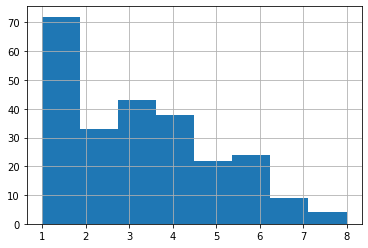

In [834]:
starting_P.hist(bins = 8)

# Getting each game in a single row
Now we'll manipulate the odds dataframe so that all the features of each game are on a single row. We'll confirm that all the even indexes are visiting teams and all the odd indexes are home teams and drop the 'VH' column.<br>

Then the split_odds_df function basically takes indexes as arguments. The step part of the slice will be 2 both times since we're slicing every other row both times. The odds_df_v df will have the date of the game and the odds_df_h will have the over/under (predicted combined runs for each team).<br>

We rename columns to make home and visiting teams clear and put the dataframes back together in odds_df_all.

In [835]:
odds_df.iloc[0::2, 1].unique()

array(['V'], dtype=object)

In [836]:
odds_df.iloc[1::2, 1].unique()

array(['H'], dtype=object)

In [837]:
odds_df.drop(columns = 'VH', inplace = True)

In [838]:
def split_odds_df(first_row, first_col, last_col):
    odds_df_split = odds_df.iloc[first_row::2, first_col:last_col]
    odds_df_split.reset_index(drop = True, inplace = True)
    return odds_df_split

In [839]:
odds_df_v = split_odds_df(0, 0, -1)

In [840]:
odds_df_v.head()

,Date,Team,Pitcher,Open
0,501,MIA,PCAMPBELL,105
1,501,CHC,ZDAVIES,135
2,501,NYM,TWALKER,100
3,501,STL,JFLAHERTY,-135
4,501,LAD,DMAY,-115


In [841]:
odds_df_v.rename(columns = {'Team': 'V_Team', 'Pitcher': 'V_Pitcher', 'Open': 'V_Open'}, inplace = True)

In [842]:
odds_df_v.head()

,Date,V_Team,V_Pitcher,V_Open
0,501,MIA,PCAMPBELL,105
1,501,CHC,ZDAVIES,135
2,501,NYM,TWALKER,100
3,501,STL,JFLAHERTY,-135
4,501,LAD,DMAY,-115


In [843]:
odds_df_h = split_odds_df(1, 1, 5)

In [844]:
odds_df_h.head()

,Team,Pitcher,Open,OpenOU
0,WSN,PCORBIN-L,-125,8.5
1,CIN,LCASTILLO,-160,9.0
2,PHI,ZWHEELER,-120,7.5
3,PIT,TCAHILL,115,7.5
4,MIL,BWOODRUFF,-105,7.0


In [845]:
odds_df_h.rename(columns = {'Team':'H_Team', 'Pitcher':'H_Pitcher', 'Open': 'H_Open'}, inplace = True)

In [846]:
odds_df_h.head()

,H_Team,H_Pitcher,H_Open,OpenOU
0,WSN,PCORBIN-L,-125,8.5
1,CIN,LCASTILLO,-160,9.0
2,PHI,ZWHEELER,-120,7.5
3,PIT,TCAHILL,115,7.5
4,MIL,BWOODRUFF,-105,7.0


In [847]:
odds_df_v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       384 non-null    int64 
 1   V_Team     384 non-null    object
 2   V_Pitcher  384 non-null    object
 3   V_Open     384 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 12.1+ KB


In [848]:
odds_df_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   H_Team     384 non-null    object 
 1   H_Pitcher  384 non-null    object 
 2   H_Open     384 non-null    int64  
 3   OpenOU     384 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 12.1+ KB


In [849]:
odds_df_all = odds_df_v.join(odds_df_h, how = 'left')

In [850]:
odds_df_all.head(10)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0
5,501,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0
6,501,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0
7,501,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0
8,501,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0
9,501,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5


# Distribution of money lines
Rather than point spreads, which are used in sports like basketball and football, baseball betting is based on money lines. Favorites have a money line that starts with a minus and underdogs have one that starts with a plus.<br>

If you bet on a -150 favorite, you'd have to bet 150 dollars to win back your money plus 100 dollars. If you bet on a +150 underdog, you can bet 100 and make that back plus 150 if your team wins. This is why money lines are always 100 or more either way.<br>

Here's a look at the distribution of money lines in odds_df_all.

<AxesSubplot:>

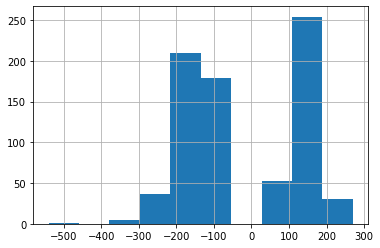

In [851]:
odds_df['Open'].hist()

# A little math
Now we'll use the money line and over-under to derive a projected-runs feature for each team in each game.<br>

We'll start by creating a win probability column for each team and assigning .5 as a baseline value.

In [852]:
odds_df_all['V_Win_Prob'] = .5
odds_df_all['H_Win_Prob'] = .5

In [853]:
odds_df_all.head()

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.5,0.5
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.5,0.5
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.5,0.5
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.5,0.5
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.5,0.5


# Algorithm to process money lines
If a moneyline is +300 or more, the team automatically is given a win probability of .25. If it's -300 or more the other way, the probability is .75.<br>

In all other cases, we add 100 to underdog lines and subtract 100 from favorite lines so they meet at zero, then add 200 to all of them so we have a number between 0 and 400. We multiply by .00125. The higher the number (remember underdogs' money lines start with a + sign), the less of a probability that team has to win, so that scaled number between 0 and 400 multiplied by .00125 is subtracted from .75, our highest possible win probabilty.

In [854]:
def create_win_prob(df, col1, col2):
    for i in range(len(df)):
        moneyline = df.iloc[i, col1]
        overunder = df.iloc[i, 7]
        if moneyline < -300:
            df.iloc[i, col2] = .75
        elif moneyline > 300:
            df.iloc[i, col2] = .25
        else:
            if moneyline < 0:
                moneyline = moneyline + 100
            else:
                moneyline = moneyline - 100
            moneyline = moneyline + 200
            win_prob = .75 - moneyline * .00125
            df.iloc[i, col2] = win_prob

In [855]:
create_win_prob(odds_df_all, 3, 8)
create_win_prob(odds_df_all, 6, 9)
#create_proj_runs(odds_df_all, 3, 8)
#create_proj_runs(odds_df_all, 6, 9)

In [856]:
odds_df_all.head(30)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.49375,0.53125
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.45625,0.57500
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.50000,0.52500
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.54375,0.48125
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.51875,0.50625
5,501,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0,0.43750,0.60000
6,501,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0,0.44375,0.58750
7,501,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0,0.40625,0.63750
8,501,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0,0.50625,0.51875
9,501,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5,0.44375,0.58750


# That doesn't add up
Most of these win probabilities add up to a number greater than one because the money lines aren't symmetrical. In Miami at Washington, our first game on May 1, Washington is a -125 favorite. We'd expect, then, that Miami would be a +125 underdog, but instead they're +105. We're not experts here when it comes to betting on games, but the theory is that Vegas wouldn't make money if the money lines matched up on both sides.<br>

So what we'll do is figure out the difference between the total of the win probabilities and 1 (prob_overset), split that number and subtract equally from both V_Win_Prob and H_Win_Prob.


In [857]:
odds_df_all['prob_overset'] = odds_df_all['V_Win_Prob'] + odds_df_all['H_Win_Prob'] - 1
odds_df_all['V_Win_Prob'] = odds_df_all['V_Win_Prob'] - odds_df_all['prob_overset'] / 2
odds_df_all['H_Win_Prob'] = odds_df_all['H_Win_Prob'] - odds_df_all['prob_overset'] / 2

In [858]:
odds_df_all.head(30)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_overset
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,0.02500
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,0.03125
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,0.02500
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,0.02500
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,0.02500
5,501,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0,0.418750,0.581250,0.03750
6,501,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0,0.428125,0.571875,0.03125
7,501,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0,0.384375,0.615625,0.04375
8,501,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0,0.493750,0.506250,0.02500
9,501,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5,0.428125,0.571875,0.03125


# Splitting the over-under
Finally, we'll multiply these win probabilities for each team by the over-under to get a projected run total for both teams in each game.<br>

In lieu of the specific pitcher a team is facing and his stats, this projected runs metric hints at the quality of pitcher a player will face in that game. A high projected run total suggests that the batter is facing a weak pitcher and has a good chance to score a lot of fantasy points.<br>

In [859]:
odds_df_all['V_Proj_Runs'] = odds_df_all['V_Win_Prob'] * odds_df_all['OpenOU']

In [860]:
odds_df_all['H_Proj_Runs'] = odds_df_all['H_Win_Prob'] * odds_df_all['OpenOU']

In [861]:
odds_df_all.head(50)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_overset,V_Proj_Runs,H_Proj_Runs
0,501,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,0.02500,4.090625,4.409375
1,501,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,0.03125,3.965625,5.034375
2,501,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,0.02500,3.656250,3.843750
3,501,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,0.02500,3.984375,3.515625
4,501,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,0.02500,3.543750,3.456250
5,501,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0,0.418750,0.581250,0.03750,3.350000,4.650000
6,501,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0,0.428125,0.571875,0.03125,2.996875,4.003125
7,501,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0,0.384375,0.615625,0.04375,3.075000,4.925000
8,501,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0,0.493750,0.506250,0.02500,4.443750,4.556250
9,501,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5,0.428125,0.571875,0.03125,3.639062,4.860938


# Take me out to the park

Now we'll start the process of adding ballpark factors.<br>

First, we add a Park column to the odds dataframe by simply copying the home team 'H_Team' column. The ballpark where the game is played is obviously the ballpark of the home team.

In [862]:
odds_df_all['Park'] = odds_df_all['H_Team']

# O Canada
Nothing can ever be that simple.<br>

Because of COVID-19 restrictions, the Toronto Blue Jays, the only MLB team based in Canada, could not play in Canada until August. They played their home games in Dunedin, Fla., in May and in Buffalo in June and July. So we'll make a list of the six dates where we need to change 'TOR' to 'BUF' in the Park column and then change them.

In [863]:
#Blue Jays home games
# May 1 Dunedin
# MAy 21 Dunedin
# June 2 Buffalo
# June 6 Buffalo
# June 26 Buffalo
# June 30 Buffalo
# July 4 Buffalo
# July 16 Buffalo
# Aug 1 Toronto
# Aug 5 Toronto
# Aug 21 Toronto
# Aug 25 Toronto 
tor_buf_dates = [602, 606, 626, 630, 704, 716]

In [864]:
odds_df_all[(odds_df_all['Date'].isin(tor_buf_dates)) & (odds_df_all['Park'] == 'TOR')]

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_overset,V_Proj_Runs,H_Proj_Runs,Park
112,602,MIA,PLOPEZ,130,TOR,AMANOAH,-150,8.5,0.450000,0.550000,0.02500,3.825000,4.675000,TOR
122,606,HOU,LGARCIA,100,TOR,SMATZ-L,-120,10.0,0.487500,0.512500,0.02500,4.875000,5.125000,TOR
188,626,BAL,KAKIN-L,220,TOR,HRYU-L,-270,10.0,0.318750,0.681250,0.06250,3.187500,6.812500,TOR
200,630,SEA,JSHEFFIEL-L,155,TOR,SMATZ-L,-185,10.5,0.412500,0.587500,0.03750,4.331250,6.168750,TOR
213,704,TBR,RYARBROUG-L,135,TOR,RRAY-L,-160,9.5,0.440625,0.559375,0.03125,4.185937,5.314062,TOR
236,716,TEX,JLYLES,190,TOR,RRAY-L,-235,10.0,0.359375,0.640625,0.05625,3.593750,6.406250,TOR


In [865]:
indexes_to_change = [112, 122, 188, 200, 213, 236]

In [866]:
odds_df_all.iloc[indexes_to_change, 13] = 'BUF'

In [867]:
odds_df_all.iloc[indexes_to_change, :]

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_overset,V_Proj_Runs,H_Proj_Runs,Park
112,602,MIA,PLOPEZ,130,TOR,AMANOAH,-150,8.5,0.450000,0.550000,0.02500,3.825000,4.675000,BUF
122,606,HOU,LGARCIA,100,TOR,SMATZ-L,-120,10.0,0.487500,0.512500,0.02500,4.875000,5.125000,BUF
188,626,BAL,KAKIN-L,220,TOR,HRYU-L,-270,10.0,0.318750,0.681250,0.06250,3.187500,6.812500,BUF
200,630,SEA,JSHEFFIEL-L,155,TOR,SMATZ-L,-185,10.5,0.412500,0.587500,0.03750,4.331250,6.168750,BUF
213,704,TBR,RYARBROUG-L,135,TOR,RRAY-L,-160,9.5,0.440625,0.559375,0.03125,4.185937,5.314062,BUF
236,716,TEX,JLYLES,190,TOR,RRAY-L,-235,10.0,0.359375,0.640625,0.05625,3.593750,6.406250,BUF


## Now we'll change those dates to datetime type

In [868]:
odds_df_all.Date = odds_df_all.Date.astype(str)

In [869]:
odds_df_all['Date'] = '20210' + odds_df_all['Date'] 

In [870]:
odds_df_all['Date'] = pd.to_datetime(odds_df_all['Date'], format = '%Y%m%d')

# How handy is this?
The strings that represent the name of each pitcher in our odds dataframe end with '-L' if that pitcher is left-handed. So to create the column that indicates whether our observed batter is facing a right-handed or left-handed starting pitcher, we check the last two characters of each string.<br>

Now this doesn't necessarily mean that batter will face that hand for the entire game. Starting pitchers almost never finish games, and a right-hander can be relieved by a lefty and vice versa. As we see in the next three cells, in our small sample size starting pitchers averaged about five innings per game. That's enough for most batters to face the starting pitcher at least twice. But is the handedness of the starting pitcher overrated? That's a good question that we'll try to answer.

In [871]:
pitching_df['IP'] = pitching_df['IP'] + (pitching_df['IP2'] * 0.33)

In [872]:
pitching_df.head()

,Name,W,IP,ER,SO,QS,IP2,FD_Pts
0,Jose Urquidy,1,7.00,0,5,4,0.0,42.0
1,Travis Bergen,0,1.00,0,0,0,0.0,3.0
2,Griffin Canning,1,5.33,0,9,0,1.0,49.0
3,Danny Duffy,1,7.00,1,7,4,0.0,45.0
4,Jameson Taillon,1,5.00,1,8,0,0.0,42.0


In [873]:
pitching_df['IP'].mean()

5.119636363636364

In [874]:
odds_df_all['H_Opp_Hand'] = np.where(odds_df_all['V_Pitcher'].str[-2:] == '-L', 'L', 'R')

In [875]:
odds_df_all['V_Opp_Hand'] = np.where(odds_df_all['H_Pitcher'].str[-2:] == '-L', 'L', 'R')

In [876]:
odds_df_all.head(10)

,Date,V_Team,V_Pitcher,V_Open,H_Team,H_Pitcher,H_Open,OpenOU,V_Win_Prob,H_Win_Prob,prob_overset,V_Proj_Runs,H_Proj_Runs,Park,H_Opp_Hand,V_Opp_Hand
0,2021-05-01,MIA,PCAMPBELL,105,WSN,PCORBIN-L,-125,8.5,0.481250,0.518750,0.02500,4.090625,4.409375,WSN,R,L
1,2021-05-01,CHC,ZDAVIES,135,CIN,LCASTILLO,-160,9.0,0.440625,0.559375,0.03125,3.965625,5.034375,CIN,R,R
2,2021-05-01,NYM,TWALKER,100,PHI,ZWHEELER,-120,7.5,0.487500,0.512500,0.02500,3.656250,3.843750,PHI,R,R
3,2021-05-01,STL,JFLAHERTY,-135,PIT,TCAHILL,115,7.5,0.531250,0.468750,0.02500,3.984375,3.515625,PIT,R,R
4,2021-05-01,LAD,DMAY,-115,MIL,BWOODRUFF,-105,7.0,0.506250,0.493750,0.02500,3.543750,3.456250,MIL,R,R
5,2021-05-01,COL,AGOMBER-L,150,ARI,ZGALLEN,-180,8.0,0.418750,0.581250,0.03750,3.350000,4.650000,ARI,L,R
6,2021-05-01,SFG,ADESCLAFA,145,SDP,BSNELL-L,-170,7.0,0.428125,0.571875,0.03125,2.996875,4.003125,SDP,R,L
7,2021-05-01,DET,STURNBULL,175,NYY,JTAILLON,-210,8.0,0.384375,0.615625,0.04375,3.075000,4.925000,NYY,R,R
8,2021-05-01,KCR,DDUFFY-L,-105,MIN,MSHOEMAKE,-115,9.0,0.493750,0.506250,0.02500,4.443750,4.556250,MIN,L,R
9,2021-05-01,CLE,TMCKENZIE,145,CHW,LLYNN,-170,8.5,0.428125,0.571875,0.03125,3.639062,4.860938,CHW,R,R


In [877]:
odds_df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          384 non-null    datetime64[ns]
 1   V_Team        384 non-null    object        
 2   V_Pitcher     384 non-null    object        
 3   V_Open        384 non-null    int64         
 4   H_Team        384 non-null    object        
 5   H_Pitcher     384 non-null    object        
 6   H_Open        384 non-null    int64         
 7   OpenOU        384 non-null    float64       
 8   V_Win_Prob    384 non-null    float64       
 9   H_Win_Prob    384 non-null    float64       
 10  prob_overset  384 non-null    float64       
 11  V_Proj_Runs   384 non-null    float64       
 12  H_Proj_Runs   384 non-null    float64       
 13  Park          384 non-null    object        
 14  H_Opp_Hand    384 non-null    object        
 15  V_Opp_Hand    384 non-null    object    

# Breaking it all down again
We built up that odds dataframe only to break it back down.<br>

We need each row to contain one team and one date so we can join with our main dataframe on Date and Team. Here we'll take only the columns we need and rename them so it's the same for both home and visiting teams, then concatenate. 

In [878]:
odds_df_visitors = odds_df_all[['Date', 'V_Team', 'V_Proj_Runs', 'V_Opp_Hand', 'Park']].copy()
odds_df_visitors.rename(columns = {'V_Team':'Team', 'V_Proj_Runs':'Proj_Runs', 'V_Opp_Hand':'Opp_Hand'}, inplace = True)
odds_df_home = odds_df_all[['Date', 'H_Team', 'H_Proj_Runs', 'H_Opp_Hand', 'Park']].copy()
odds_df_home.rename(columns = {'H_Team':'Team', 'H_Proj_Runs':'Proj_Runs', 'H_Opp_Hand':'Opp_Hand'}, inplace = True)

In [879]:
odds_df_visitors.head()

,Date,Team,Proj_Runs,Opp_Hand,Park
0,2021-05-01,MIA,4.090625,L,WSN
1,2021-05-01,CHC,3.965625,R,CIN
2,2021-05-01,NYM,3.656250,R,PHI
3,2021-05-01,STL,3.984375,R,PIT
4,2021-05-01,LAD,3.543750,R,MIL


In [880]:
odds_df_visitors.tail()

,Date,Team,Proj_Runs,Opp_Hand,Park
379,2021-08-29,KCR,3.639062,L,SEA
380,2021-08-29,NYY,4.893750,R,OAK
381,2021-08-29,CHC,3.267188,R,CHW
382,2021-08-29,MIL,5.375000,R,MIN
383,2021-06-26,SEA,3.200000,R,CHW


In [881]:
odds_df_home.head()

,Date,Team,Proj_Runs,Opp_Hand,Park
0,2021-05-01,WSN,4.409375,R,WSN
1,2021-05-01,CIN,5.034375,R,CIN
2,2021-05-01,PHI,3.843750,R,PHI
3,2021-05-01,PIT,3.515625,R,PIT
4,2021-05-01,MIL,3.456250,R,MIL


In [882]:
odds_df_home.tail()

,Date,Team,Proj_Runs,Opp_Hand,Park
379,2021-08-29,SEA,4.860938,R,SEA
380,2021-08-29,OAK,4.106250,L,OAK
381,2021-08-29,CHW,5.232812,R,CHW
382,2021-08-29,MIN,4.625000,L,MIN
383,2021-06-26,CHW,4.800000,R,CHW


In [883]:
odds_df_ready = pd.concat([odds_df_visitors, odds_df_home], ignore_index = True)

In [884]:
odds_df_ready.head(20)

,Date,Team,Proj_Runs,Opp_Hand,Park
0,2021-05-01,MIA,4.090625,L,WSN
1,2021-05-01,CHC,3.965625,R,CIN
2,2021-05-01,NYM,3.656250,R,PHI
3,2021-05-01,STL,3.984375,R,PIT
4,2021-05-01,LAD,3.543750,R,MIL
5,2021-05-01,COL,3.350000,R,ARI
6,2021-05-01,SFG,2.996875,L,SDP
7,2021-05-01,DET,3.075000,R,NYY
8,2021-05-01,KCR,4.443750,R,MIN
9,2021-05-01,CLE,3.639062,R,CHW


In [885]:
odds_df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       768 non-null    datetime64[ns]
 1   Team       768 non-null    object        
 2   Proj_Runs  768 non-null    float64       
 3   Opp_Hand   768 non-null    object        
 4   Park       768 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 30.1+ KB


# Another merger

And now we merge odds with the main dataframe so that each observation now includes the projected runs of that player's team for that day (the same for all players on that team on that day), the handedness of that player's opposing starting pitcher and the ballpark where that player is playing.

In [886]:
main_df = main_df.merge(odds_df_ready, on = ['Date', 'Team'], how = 'left')

In [887]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+,Bats,Proj_Runs,Opp_Hand,Park
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,39.1%,29.7%,43.8%,35.9%,20.3%,155.0,L,4.568750,R,SEA
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,60.0%,26.7%,35.0%,30.0%,35.0%,75.0,L,4.443750,R,MIN
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,40.6%,39.1%,42.0%,31.9%,26.1%,111.0,R,4.443750,R,MIN
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,47.1%,32.4%,35.3%,35.3%,29.4%,105.0,L,3.559375,L,TEX
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,54.1%,23.0%,33.8%,37.8%,28.4%,84.0,S,3.075000,R,NYY


In [888]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5785 entries, 0 to 5784
Data columns (total 60 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5785 non-null   datetime64[ns]
 1   Name        5785 non-null   object        
 2   Team        5785 non-null   object        
 3   PA_Game     5785 non-null   int64         
 4   1B          5785 non-null   int64         
 5   2B          5785 non-null   int64         
 6   3B          5785 non-null   int64         
 7   HR          5785 non-null   int64         
 8   RBI         5785 non-null   int64         
 9   R           5785 non-null   int64         
 10  BB          5785 non-null   int64         
 11  SB          5785 non-null   int64         
 12  HBP         5785 non-null   int64         
 13  playerid    5785 non-null   int64         
 14  PA          5785 non-null   float64       
 15  Events      5785 non-null   float64       
 16  EV          5785 non-nul

In [889]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [890]:
null_data

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Med%,Hard%,Pull%,Cent%,Oppo%,wRC+,Bats,Proj_Runs,Opp_Hand,Park


# Park factors

Now we go to MLB.com to get features that measure how conducive each ballpark is to hitting, both overall hitting and home runs.<br>

We also can break this down by handedness, as some ballparks favor one hand of batter more than another. We'll have overall park factors and home run park factors (numbers where 100 is the baseline) for both right-handed and left-handed hitters. For switch-hitters we'll use the park factors that don't take handedness into account.

In [891]:
parks_df = pd.read_excel('MLBParkFactorsAll.xlt')

In [892]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,Rockies,110,109,R
1,Reds,107,122,R
2,Orioles,106,133,R
3,Red Sox,105,102,R
4,Royals,104,89,R


In [893]:
parks_df.tail()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
85,Blue Jays,96,95,S
86,Rays,95,84,S
87,Athletics,95,89,S
88,Mariners,94,96,S
89,Cardinals,94,82,S


# That's an ugly string
These next 17 or so cells just convert the team names in the parks dataframe to match our three-letter code in the main dataframe.<br>

The park team names were pasted directly from MLB.com into a spreadsheet, which might explain that ugly '\xa0' before each team name. We could figure out the index where the team name starts to get around the problem, but there might be a time later in our career when we can't get around this problem. So this question was posted on Stack Overflow and we understood the answer just enough to solve our problem, with the help of the unidecode package.

In [894]:
park_team_names = list(parks_df['Park'])

In [895]:
park_team_names[:10]

['\xa0Rockies',
 '\xa0Reds',
 '\xa0Orioles',
 '\xa0Red Sox',
 '\xa0Royals',
 '\xa0Pirates',
 '\xa0Dodgers',
 '\xa0Nationals',
 '\xa0Indians',
 '\xa0White Sox']

In [896]:
import unidecode

In [897]:
parks_df['Park'] = [unidecode.unidecode(team_name).strip() for team_name in parks_df['Park']]

In [898]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,Rockies,110,109,R
1,Reds,107,122,R
2,Orioles,106,133,R
3,Red Sox,105,102,R
4,Royals,104,89,R


In [899]:
park_team_names = list(parks_df['Park'])

In [900]:
park_team_names[:10]

['Rockies',
 'Reds',
 'Orioles',
 'Red Sox',
 'Royals',
 'Pirates',
 'Dodgers',
 'Nationals',
 'Indians',
 'White Sox']

In [901]:
parks_team_list = list(parks_df['Park'].unique())

In [902]:
team_codes

array(['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM',
       'ATL', 'COL', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA', 'CHW',
       'MIA', 'PIT', 'NYY', 'SFG', 'CIN', 'CLE', 'SDP', 'MIN', 'BAL',
       'HOU', 'TBR', 'TOR'], dtype=object)

In [903]:
parks_code_list = list(team_codes)

In [904]:
print(parks_team_list)

['Rockies', 'Reds', 'Orioles', 'Red Sox', 'Royals', 'Pirates', 'Dodgers', 'Nationals', 'Indians', 'White Sox', 'Angels', 'Braves', 'Brewers', 'Yankees', 'Astros', 'Cubs', 'D-backs', 'Twins', 'Phillies', 'Giants', 'Tigers', 'Rangers', 'Mets', 'Padres', 'Marlins', 'Blue Jays', 'Rays', 'Mariners', 'Cardinals', 'Athletics']


In [905]:
print(parks_code_list)

['LAA', 'KCR', 'TEX', 'DET', 'ARI', 'PHI', 'CHC', 'STL', 'NYM', 'ATL', 'COL', 'LAD', 'WSN', 'BOS', 'OAK', 'MIL', 'SEA', 'CHW', 'MIA', 'PIT', 'NYY', 'SFG', 'CIN', 'CLE', 'SDP', 'MIN', 'BAL', 'HOU', 'TBR', 'TOR']


In [906]:
park_codes_ordered = ['COL', 'CIN', 'BAL', 'BOS', 'KCR', 'PIT', 'LAD', 'WSN', 'CLE', 'CHW', \
                     'LAA', 'ATL', 'MIL', 'NYY', 'HOU', 'CHC', 'ARI', 'MIN', 'PHI', 'SFG', \
                     'DET', 'TEX', 'NYM', 'SDP', 'MIA', 'TOR', 'TBR', 'SEA', 'STL', 'OAK']

In [907]:
park_teams_dict = dict(zip(parks_team_list, park_codes_ordered))

In [908]:
park_teams_dict

{'Rockies': 'COL',
 'Reds': 'CIN',
 'Orioles': 'BAL',
 'Red Sox': 'BOS',
 'Royals': 'KCR',
 'Pirates': 'PIT',
 'Dodgers': 'LAD',
 'Nationals': 'WSN',
 'Indians': 'CLE',
 'White Sox': 'CHW',
 'Angels': 'LAA',
 'Braves': 'ATL',
 'Brewers': 'MIL',
 'Yankees': 'NYY',
 'Astros': 'HOU',
 'Cubs': 'CHC',
 'D-backs': 'ARI',
 'Twins': 'MIN',
 'Phillies': 'PHI',
 'Giants': 'SFG',
 'Tigers': 'DET',
 'Rangers': 'TEX',
 'Mets': 'NYM',
 'Padres': 'SDP',
 'Marlins': 'MIA',
 'Blue Jays': 'TOR',
 'Rays': 'TBR',
 'Mariners': 'SEA',
 'Cardinals': 'STL',
 'Athletics': 'OAK'}

In [909]:
parks_df['Park'].replace(park_teams_dict, inplace = True)

In [910]:
parks_df.head()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
0,COL,110,109,R
1,CIN,107,122,R
2,BAL,106,133,R
3,BOS,105,102,R
4,KCR,104,89,R


# Handling the Toronto problem
The 2021 park factors only include the Blue Jays' home park in Toronto. That's fine for the August games, but what about Dunedin and Buffalo? We do have 2020 numbers for the Buffalo park. We'll just use that here. We don't have Dunedin numbers. We'll eventually drop May games in which the Blue Jays were the home team.

In [911]:
# BUF Pk_Fct_R Overall 99 HR 86
#BUF Pk_Fct L Overall 102 HR 88
#S 100 86

# June 26 White Sox -195 Mariners +165 both RHP OU 8

In [912]:
parks_add = pd.DataFrame([['BUF', 99, 86, 'R'], ['BUF', 102, 88, 'L'], ['BUF', 100, 86, 'S']], \
                         columns = ['Park', 'Pk_Fct_Overall', 'Pk_Fct_HR', 'Bats'])

In [913]:
parks_df = parks_df.append(parks_add, ignore_index = True)

In [914]:
parks_df.tail()

,Park,Pk_Fct_Overall,Pk_Fct_HR,Bats
88,SEA,94,96,S
89,STL,94,82,S
90,BUF,99,86,R
91,BUF,102,88,L
92,BUF,100,86,S


# And we merge once again

In [915]:
main_df = main_df.merge(parks_df, on = ['Park', 'Bats'], how = 'left')

In [916]:
main_df.head()

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Pull%,Cent%,Oppo%,wRC+,Bats,Proj_Runs,Opp_Hand,Park,Pk_Fct_Overall,Pk_Fct_HR
0,2021-05-01,Jared Walsh,LAA,5,2,0,0,2,3,2,...,43.8%,35.9%,20.3%,155.0,L,4.568750,R,SEA,95,99
1,2021-05-01,Andrew Benintendi,KCR,4,1,0,0,2,2,3,...,35.0%,30.0%,35.0%,75.0,L,4.443750,R,MIN,100,106
2,2021-05-01,Salvador Perez,KCR,3,0,1,0,1,3,2,...,42.0%,31.9%,26.1%,111.0,R,4.443750,R,MIN,98,96
3,2021-05-01,Willie Calhoun,TEX,4,1,1,0,1,2,2,...,35.3%,35.3%,29.4%,105.0,L,3.559375,L,TEX,100,102
4,2021-05-01,Jeimer Candelario,DET,4,2,0,0,1,1,1,...,33.8%,37.8%,28.4%,84.0,S,3.075000,R,NYY,99,109


In [917]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5785 entries, 0 to 5784
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5785 non-null   datetime64[ns]
 1   Name            5785 non-null   object        
 2   Team            5785 non-null   object        
 3   PA_Game         5785 non-null   int64         
 4   1B              5785 non-null   int64         
 5   2B              5785 non-null   int64         
 6   3B              5785 non-null   int64         
 7   HR              5785 non-null   int64         
 8   RBI             5785 non-null   int64         
 9   R               5785 non-null   int64         
 10  BB              5785 non-null   int64         
 11  SB              5785 non-null   int64         
 12  HBP             5785 non-null   int64         
 13  playerid        5785 non-null   int64         
 14  PA              5785 non-null   float64       
 15  Even

In [918]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [919]:
null_data

,Date,Name,Team,PA_Game,1B,2B,3B,HR,RBI,R,...,Pull%,Cent%,Oppo%,wRC+,Bats,Proj_Runs,Opp_Hand,Park,Pk_Fct_Overall,Pk_Fct_HR


## Dropping Blue Jays May home games

In [920]:
tor_dict = {'20210501': ['TOR'], '20210521': ['TOR']}

In [921]:
for key, value in tor_dict.items():
    temp_date = pd.to_datetime(key, format = '%Y%m%d')
    main_df = main_df.loc[~((main_df['Date'] == temp_date) & (main_df['Park'].isin(value))), :]

In [922]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5755 entries, 0 to 5784
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5755 non-null   datetime64[ns]
 1   Name            5755 non-null   object        
 2   Team            5755 non-null   object        
 3   PA_Game         5755 non-null   int64         
 4   1B              5755 non-null   int64         
 5   2B              5755 non-null   int64         
 6   3B              5755 non-null   int64         
 7   HR              5755 non-null   int64         
 8   RBI             5755 non-null   int64         
 9   R               5755 non-null   int64         
 10  BB              5755 non-null   int64         
 11  SB              5755 non-null   int64         
 12  HBP             5755 non-null   int64         
 13  playerid        5755 non-null   int64         
 14  PA              5755 non-null   float64       
 15  Even

# Wait, where are the target variables?

We have to calculate them. While home runs are far and away the most important component of MLB DFS production, we also need to look at singles, doubles, triples, runs scored, runs batted in, stolen bases, walks and hit-by-pitcher to get complete scoring on FanDuel and DraftKings.

In [923]:
main_df['FD_Pts'] = (main_df['1B'] * 3) + (main_df['2B'] * 6) + (main_df['3B'] * 9) + (main_df['HR'] * 12) \
+ (main_df['RBI'] * 3.5) + (main_df['R'] * 3.2) + (main_df['BB'] * 3) + (main_df['SB'] * 6) + (main_df['HBP'] * 3) 

In [924]:
main_df['DK_Pts'] = (main_df['1B'] * 3) + (main_df['2B'] * 5) + (main_df['3B'] * 8) + (main_df['HR'] * 10) \
+ (main_df['RBI'] * 2) + (main_df['R'] * 2) + (main_df['BB'] * 2) + (main_df['SB'] * 5) + (main_df['HBP'] * 2) 

In [925]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5755 entries, 0 to 5784
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5755 non-null   datetime64[ns]
 1   Name            5755 non-null   object        
 2   Team            5755 non-null   object        
 3   PA_Game         5755 non-null   int64         
 4   1B              5755 non-null   int64         
 5   2B              5755 non-null   int64         
 6   3B              5755 non-null   int64         
 7   HR              5755 non-null   int64         
 8   RBI             5755 non-null   int64         
 9   R               5755 non-null   int64         
 10  BB              5755 non-null   int64         
 11  SB              5755 non-null   int64         
 12  HBP             5755 non-null   int64         
 13  playerid        5755 non-null   int64         
 14  PA              5755 non-null   float64       
 15  Even

In [926]:
main_df.describe()

,PA_Game,1B,2B,3B,HR,RBI,R,BB,SB,HBP,...,BABIP,GB/FB,BsR,UBR,wRC+,Proj_Runs,Pk_Fct_Overall,Pk_Fct_HR,FD_Pts,DK_Pts
count,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,...,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000
mean,4.170287,0.597394,0.188358,0.011121,0.140226,0.497828,0.524066,0.370287,0.047785,0.050043,...,0.297664,1.310311,0.019444,0.012858,104.120070,4.385160,99.833536,99.622242,9.672233,7.348566
std,0.680315,0.724966,0.433202,0.104876,0.376545,0.888728,0.713763,0.600069,0.227521,0.225112,...,0.070996,0.683622,0.632086,0.371300,42.445074,0.827070,3.857393,14.616145,9.941067,7.331265
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.036000,0.080000,-2.000000,-1.900000,-43.000000,1.746875,93.000000,68.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.253000,0.860000,-0.400000,-0.200000,76.000000,3.843750,97.000000,89.000000,3.000000,2.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.296000,1.160000,0.000000,0.000000,104.000000,4.331250,100.000000,98.000000,6.200000,5.000000
75%,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.341000,1.590000,0.400000,0.300000,131.000000,4.871875,102.000000,107.000000,13.000000,11.000000
max,7.000000,4.000000,3.000000,1.000000,3.000000,7.000000,5.000000,4.000000,3.000000,2.000000,...,0.609000,9.000000,5.100000,1.300000,271.000000,7.356250,110.000000,148.000000,76.300000,56.000000


In [927]:
pd.set_option('display.max_rows', None)

# Let's just make sure there are no nulls

In [928]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
Name,0,0.0
GB%,0,0.0
FB%,0,0.0
IFFB%,0,0.0
HR/FB,0,0.0
BsR,0,0.0
UBR,0,0.0
O-Swing%,0,0.0
Z-Swing%,0,0.0


In [929]:
main_df.reset_index(drop=True, inplace = True)

# Numbers disguised as strings

Apparently we have some floats dressed as strings for Halloween. Basically the numbers with percent signs after them are currently object types, so we'll start the process of converting them to floats by breaking down the main dataframe by type.

In [930]:
main_df.select_dtypes(include = object).T

,0,1,2,3,4,5,6,7,8,9,...,5745,5746,5747,5748,5749,5750,5751,5752,5753,5754
Name,Jared Walsh,Andrew Benintendi,Salvador Perez,Willie Calhoun,Jeimer Candelario,Josh Rojas,Alec Bohm,Nico Hoerner,Niko Goodrum,Isiah Kiner-Falefa,...,Kevin Newman,Ian Happ,Harrison Bader,Yuli Gurriel,Brent Rooker,Abraham Toro,Luis Garcia,Jazz Chisholm,Cal Raleigh,Ryan Jeffers
Team,LAA,KCR,KCR,TEX,DET,ARI,PHI,CHC,DET,TEX,...,PIT,CHC,STL,HOU,MIN,SEA,WSN,MIA,SEA,MIN
Barrel%,10.9%,5.0%,13.0%,2.9%,4.1%,4.8%,10.1%,4.3%,13.5%,3.4%,...,3.8%,11.3%,2.7%,4.8%,11.8%,9.4%,5.1%,8.2%,5.1%,17.6%
HardHit%,32.8%,35.0%,52.2%,41.2%,36.5%,42.9%,49.3%,47.8%,56.8%,37.1%,...,32.9%,41.9%,26.0%,41.3%,47.1%,39.6%,29.1%,44.3%,38.5%,44.1%
BB%,7.5%,11.1%,3.9%,6.7%,8.3%,13.0%,5.9%,17.1%,6.8%,3.4%,...,5.6%,9.2%,7.1%,9.6%,10.8%,8.9%,5.8%,4.8%,4.5%,4.8%
K%,20.4%,22.2%,27.5%,15.6%,23.9%,26.1%,26.5%,17.1%,41.9%,19.5%,...,5.6%,33.9%,26.5%,14.5%,29.0%,11.3%,18.3%,20.5%,34.8%,33.9%
LD%,26.6%,20.7%,26.1%,23.5%,28.4%,21.4%,23.2%,8.7%,24.3%,20.5%,...,21.5%,24.6%,15.1%,20.6%,21.6%,18.8%,16.5%,23.3%,17.9%,23.5%
GB%,37.5%,50.0%,39.1%,44.1%,35.1%,54.8%,46.4%,60.9%,27.0%,59.1%,...,36.7%,41.0%,42.5%,46.0%,47.1%,34.4%,62.0%,45.0%,30.8%,47.1%
FB%,35.9%,29.3%,34.8%,32.4%,36.5%,23.8%,30.4%,30.4%,48.6%,20.5%,...,41.8%,34.4%,42.5%,33.3%,31.4%,46.9%,21.5%,31.7%,51.3%,29.4%
IFFB%,26.1%,5.9%,8.3%,36.4%,3.7%,0.0%,9.5%,0.0%,0.0%,0.0%,...,9.1%,9.5%,22.6%,0.0%,6.3%,4.4%,0.0%,15.8%,15.0%,30.0%


In [931]:
main_df_obj = main_df.select_dtypes(include=['object', 'datetime64[ns]'])

In [932]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5755 entries, 0 to 5754
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5755 non-null   datetime64[ns]
 1   Name        5755 non-null   object        
 2   Team        5755 non-null   object        
 3   Barrel%     5755 non-null   object        
 4   HardHit%    5755 non-null   object        
 5   BB%         5755 non-null   object        
 6   K%          5755 non-null   object        
 7   LD%         5755 non-null   object        
 8   GB%         5755 non-null   object        
 9   FB%         5755 non-null   object        
 10  IFFB%       5755 non-null   object        
 11  HR/FB       5755 non-null   object        
 12  O-Swing%    5755 non-null   object        
 13  Z-Swing%    5755 non-null   object        
 14  Swing%      5755 non-null   object        
 15  O-Contact%  5755 non-null   object        
 16  Z-Contact%  5755 non-nul

# Separating non-number objects

We'll probably want these six columns to be the first ones in the dataframe.

In [933]:
non_num_obj = main_df_obj.iloc[:, [0, 1, 2, 27, 28, 29]]

In [934]:
non_num_obj.head()

,Date,Name,Team,Bats,Opp_Hand,Park
0,2021-05-01,Jared Walsh,LAA,L,R,SEA
1,2021-05-01,Andrew Benintendi,KCR,L,R,MIN
2,2021-05-01,Salvador Perez,KCR,R,R,MIN
3,2021-05-01,Willie Calhoun,TEX,L,L,TEX
4,2021-05-01,Jeimer Candelario,DET,S,R,NYY


In [935]:
main_df_obj = main_df_obj.drop(['Date', 'Name', 'Team', 'Bats', 'Opp_Hand', 'Park'], 1)

In [936]:
main_df_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5755 entries, 0 to 5754
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Barrel%     5755 non-null   object
 1   HardHit%    5755 non-null   object
 2   BB%         5755 non-null   object
 3   K%          5755 non-null   object
 4   LD%         5755 non-null   object
 5   GB%         5755 non-null   object
 6   FB%         5755 non-null   object
 7   IFFB%       5755 non-null   object
 8   HR/FB       5755 non-null   object
 9   O-Swing%    5755 non-null   object
 10  Z-Swing%    5755 non-null   object
 11  Swing%      5755 non-null   object
 12  O-Contact%  5755 non-null   object
 13  Z-Contact%  5755 non-null   object
 14  Contact%    5755 non-null   object
 15  Zone%       5755 non-null   object
 16  F-Strike%   5755 non-null   object
 17  SwStr%      5755 non-null   object
 18  Soft%       5755 non-null   object
 19  Med%        5755 non-null   object
 20  Hard%   

In [937]:
main_df_nums = main_df.select_dtypes(include=['int64', 'float'])

In [938]:
main_df_nums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5755 entries, 0 to 5754
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PA_Game         5755 non-null   int64  
 1   1B              5755 non-null   int64  
 2   2B              5755 non-null   int64  
 3   3B              5755 non-null   int64  
 4   HR              5755 non-null   int64  
 5   RBI             5755 non-null   int64  
 6   R               5755 non-null   int64  
 7   BB              5755 non-null   int64  
 8   SB              5755 non-null   int64  
 9   HBP             5755 non-null   int64  
 10  playerid        5755 non-null   int64  
 11  PA              5755 non-null   float64
 12  Events          5755 non-null   float64
 13  EV              5755 non-null   float64
 14  maxEV           5755 non-null   float64
 15  LA              5755 non-null   float64
 16  Barrels         5755 non-null   float64
 17  HardHit         5755 non-null   f

In [939]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
0,10.9%,32.8%,7.5%,20.4%,26.6%,37.5%,35.9%,26.1%,17.4%,34.7%,...,79.5%,37.9%,46.2%,9.5%,31.3%,39.1%,29.7%,43.8%,35.9%,20.3%
1,5.0%,35.0%,11.1%,22.2%,20.7%,50.0%,29.3%,5.9%,5.9%,28.8%,...,76.3%,43.4%,57.8%,11.4%,13.3%,60.0%,26.7%,35.0%,30.0%,35.0%
2,13.0%,52.2%,3.9%,27.5%,26.1%,39.1%,34.8%,8.3%,20.8%,50.2%,...,67.1%,35.1%,67.6%,19.1%,20.3%,40.6%,39.1%,42.0%,31.9%,26.1%
3,2.9%,41.2%,6.7%,15.6%,23.5%,44.1%,32.4%,36.4%,9.1%,31.0%,...,83.1%,37.0%,55.6%,6.5%,20.6%,47.1%,32.4%,35.3%,35.3%,29.4%
4,4.1%,36.5%,8.3%,23.9%,28.4%,35.1%,36.5%,3.7%,3.7%,35.8%,...,77.7%,43.8%,76.1%,11.4%,23.0%,54.1%,23.0%,33.8%,37.8%,28.4%


# Removing percentage sign and changing strings to numeric type
Notice the function that is commented out. That took way too long to run. Stack Overflow to the rescue again.

In [940]:
main_df_obj_cols = list(main_df_obj.columns)

In [941]:
main_df_obj[main_df_obj_cols] = main_df_obj[main_df_obj_cols].replace({'\%':''}, regex = True)

In [942]:
#def remove_pct(rows, cols, df):
#    for i in range(rows):
#        for j in range(cols):
#            df.iloc[i, j] = df.iloc[i, j].strip('%')

In [943]:
#remove_pct(5755, 24, main_df_obj)

In [944]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
0,10.9,32.8,7.5,20.4,26.6,37.5,35.9,26.1,17.4,34.7,...,79.5,37.9,46.2,9.5,31.3,39.1,29.7,43.8,35.9,20.3
1,5.0,35.0,11.1,22.2,20.7,50.0,29.3,5.9,5.9,28.8,...,76.3,43.4,57.8,11.4,13.3,60.0,26.7,35.0,30.0,35.0
2,13.0,52.2,3.9,27.5,26.1,39.1,34.8,8.3,20.8,50.2,...,67.1,35.1,67.6,19.1,20.3,40.6,39.1,42.0,31.9,26.1
3,2.9,41.2,6.7,15.6,23.5,44.1,32.4,36.4,9.1,31.0,...,83.1,37.0,55.6,6.5,20.6,47.1,32.4,35.3,35.3,29.4
4,4.1,36.5,8.3,23.9,28.4,35.1,36.5,3.7,3.7,35.8,...,77.7,43.8,76.1,11.4,23.0,54.1,23.0,33.8,37.8,28.4


In [945]:
def change_to_num(cols, df):
    for col in cols:
        df[col] = pd.to_numeric(df[col])  

In [946]:
change_to_num(main_df_obj_cols, main_df_obj)

In [947]:
main_df_obj.head()

,Barrel%,HardHit%,BB%,K%,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
0,10.9,32.8,7.5,20.4,26.6,37.5,35.9,26.1,17.4,34.7,...,79.5,37.9,46.2,9.5,31.3,39.1,29.7,43.8,35.9,20.3
1,5.0,35.0,11.1,22.2,20.7,50.0,29.3,5.9,5.9,28.8,...,76.3,43.4,57.8,11.4,13.3,60.0,26.7,35.0,30.0,35.0
2,13.0,52.2,3.9,27.5,26.1,39.1,34.8,8.3,20.8,50.2,...,67.1,35.1,67.6,19.1,20.3,40.6,39.1,42.0,31.9,26.1
3,2.9,41.2,6.7,15.6,23.5,44.1,32.4,36.4,9.1,31.0,...,83.1,37.0,55.6,6.5,20.6,47.1,32.4,35.3,35.3,29.4
4,4.1,36.5,8.3,23.9,28.4,35.1,36.5,3.7,3.7,35.8,...,77.7,43.8,76.1,11.4,23.0,54.1,23.0,33.8,37.8,28.4


In [948]:
main_df = pd.concat([non_num_obj, main_df_nums, main_df_obj], axis = 1)

In [949]:
main_df.head()

,Date,Name,Team,Bats,Opp_Hand,Park,PA_Game,1B,2B,3B,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
0,2021-05-01,Jared Walsh,LAA,L,R,SEA,5,2,0,0,...,79.5,37.9,46.2,9.5,31.3,39.1,29.7,43.8,35.9,20.3
1,2021-05-01,Andrew Benintendi,KCR,L,R,MIN,4,1,0,0,...,76.3,43.4,57.8,11.4,13.3,60.0,26.7,35.0,30.0,35.0
2,2021-05-01,Salvador Perez,KCR,R,R,MIN,3,0,1,0,...,67.1,35.1,67.6,19.1,20.3,40.6,39.1,42.0,31.9,26.1
3,2021-05-01,Willie Calhoun,TEX,L,L,TEX,4,1,1,0,...,83.1,37.0,55.6,6.5,20.6,47.1,32.4,35.3,35.3,29.4
4,2021-05-01,Jeimer Candelario,DET,S,R,NYY,4,2,0,0,...,77.7,43.8,76.1,11.4,23.0,54.1,23.0,33.8,37.8,28.4


In [950]:
main_df.tail()

,Date,Name,Team,Bats,Opp_Hand,Park,PA_Game,1B,2B,3B,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%
5750,2021-08-29,Abraham Toro,SEA,S,R,SEA,4,0,0,0,...,86.0,43.2,54.8,6.6,17.7,53.1,29.2,33.3,38.5,28.1
5751,2021-08-29,Luis Garcia,WSN,L,R,NYM,4,0,0,0,...,76.1,40.1,67.3,12.8,13.9,60.8,25.3,48.1,38.0,13.9
5752,2021-08-29,Jazz Chisholm,MIA,L,R,MIA,3,0,0,0,...,75.6,40.6,66.3,11.6,16.4,55.7,27.9,42.6,31.1,26.2
5753,2021-08-29,Cal Raleigh,SEA,S,R,SEA,3,0,0,0,...,65.1,45.8,72.7,21.1,20.5,66.7,12.8,43.6,30.8,25.6
5754,2021-08-29,Ryan Jeffers,MIN,R,L,MIN,4,0,0,0,...,74.0,37.6,59.7,13.1,20.6,38.2,41.2,44.1,44.1,11.8


In [951]:
null_data = main_df[main_df.isnull().any(axis=1)]

In [952]:
null_data

,Date,Name,Team,Bats,Opp_Hand,Park,PA_Game,1B,2B,3B,...,Contact%,Zone%,F-Strike%,SwStr%,Soft%,Med%,Hard%,Pull%,Cent%,Oppo%


In [953]:
missing = pd.concat([main_df.isnull().sum(), 100 * main_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Date,0,0.0
Name,0,0.0
wRC+,0,0.0
Proj_Runs,0,0.0
Pk_Fct_Overall,0,0.0
Pk_Fct_HR,0,0.0
FD_Pts,0,0.0
DK_Pts,0,0.0
Barrel%,0,0.0
HardHit%,0,0.0


In [954]:
print(all(main_df))

True


In [955]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5755 entries, 0 to 5754
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            5755 non-null   datetime64[ns]
 1   Name            5755 non-null   object        
 2   Team            5755 non-null   object        
 3   Bats            5755 non-null   object        
 4   Opp_Hand        5755 non-null   object        
 5   Park            5755 non-null   object        
 6   PA_Game         5755 non-null   int64         
 7   1B              5755 non-null   int64         
 8   2B              5755 non-null   int64         
 9   3B              5755 non-null   int64         
 10  HR              5755 non-null   int64         
 11  RBI             5755 non-null   int64         
 12  R               5755 non-null   int64         
 13  BB              5755 non-null   int64         
 14  SB              5755 non-null   int64         
 15  HBP 

## Finally, as promised, the glossary:

# Glossary and feature groupings
**Date:** Date of observed game<br>
**Name:** Name of observed player<br>
**Team:** Three-letter code for observed player's team<br>
**PA_Game:** Plate appearances made by observed player in game<br>

**The following features are from the player's observed game.**<br>
**1B**: Singles (3 FanDuel points, 3 DraftKings points)<br>
**2B:** Doubles (6 FanDuel points, 5 DraftKings points)<br>
**3B:** Triples (9 FanDuel points, 8 DraftKings points)<br>
**HR:** Home runs (12 FanDuel points, 10 DraftKings points in addition to automatic RBI and R points on both sites)<br>
**RBI:** Runs batted in (3.5 FanDuel points, 2 DraftKings points)<br>
**R:** Runs scored (3.2 FanDuel points, 2 DraftKings points)<br>
**BB:** Bases on balls or walks (3 FanDuel points, 2 DraftKings points)<br>
**SB:** Stolen bases (6 FanDuel points, 5 DraftKings points)<br>
**HBP:** When batter is hit by a pitch, allowing him to take first base (3 FanDuel points, 2 DraftKings points)<br>

**playerid:** Who knows? Could come in handy.<br>

**The following features look at a player's performance over the previous 30 days.**
**PA:** Plate appearances<br>
**Events:** Batted-ball events<br>
**EV:** Exit Velocity, the speed of the batted ball<br>
**LA:** Launch angle, the angle at which the ball leaves the bat<br>
**Barrels:** A metric based on EV and LA. The "barrel zone" begins at an EV of 98 with an LA of 26-30. As the EV increases, the range of LA within the barrel zone increases.<br>
**Barrel%:** Barrels/batted-ball events<br>
**maxEV:** Highest exit velocity a player has reached<br>
**HardHit%:** EV > 95/batted-ball event<br>
**Soft%, Medium% and Hard%:** Percentage of soft-, medium- and hard-hit balls. Unlike HardHit%, EV is not a factor. Hang time, trajectry and landing spot are the determining factors.<br>
**AVG:** Batting average, H/AB<br>
**SLG:** Slugging pct Total bases/at-bats<br>
**wOBA:** Weighted on-base average. A metric of offensive value that places increasingly greater weight on BB, HBP, 1B, 2B, 3B and HR, in that order.<br>
**wRC+:** Similar to wOBA but also takes ballpark factors into account<br>
**BB%:** Walks, aka bases on balls, divided by plate appearances<br>
**K%:** Strikeouts/plate appearances<br>
**BB/K:** Walks/strikeouts<br>
**OBP:** On-base percentage<br>
**ISO:** Slugging minus BA.<br>
**BABIP:** Batting average on balls in play. With complete DFS score being taken into account, this takes on a little more importance. Some believe it's inversely proportional to DFS production, as a lower BABIP hints that a player hasn't been lucky because he's been hitting the ball where fielders happen to be and that's bound to change.<br>
**GB/FB:** Ground balls hit/fly balls hit<br>
**LD%:** line drives/balls in play<br>
**GB%:** ground balls/balls in play<br>
**FB%:** fly balls/balls in play<br>
**IFFB%:** infield fly balls/balls in play<br>
**HR/FB:** home runs/fly balls<br>
**IFH%:** Pct of base hits that are infield hits<br>
**BsR:** Base Running. Measures a player's baserunning, taking into account stolen bases, getting caught stealing, reaching bases safely. Stolen bases and the runs (which suggest an ability to run the bases well) aren't major components of DFS scoring, but since they're now being counted this BsR could be useful.<br>
**UBR:** Ultimate base running. Used to calculate BsR. We might drop this one.<br>

**These features take a look at a player's plate discipline. How often do they swing the bat? Do they swing at pitches out of the strike zone?**<br>

**O-Swing%:** (Outside the Zone Swing Percentage) Swings at pitches outside the zone divided by pitches outside the zone.<br>
**Z-Swing%:** (Inside the Zone Swing Percentage) Swings at pitches inside the zone divided by pitches inside the zone.<br>
Swing%: (Swing Percentage) Swings divided by total pitches.
**O-Contact%:** (Outside the Zone Contact Percentage) Contact made outside the zone divided by swings outside the zone.<br>
**Z-Contact%:** (Inside the Zone Contact Percentage) Contact made inside the zone divided by swings inside the zone.<br>
**Contact%:** (Contact Percentage) Contact made divided by swings.<br>
**Zone%:** (Zone Percentage): Pitches inside the zone divided by total pitches.<br>
**F-Strike%:** (First Pitch Strike Percentage) Percentage of PA that begin with a strike.<br>
**SwStr%:** (Swinging Strike Percentage) Swinging strikes divided by total pitches.<br>

**These next three features look at where a player hits the ball. A right-handed hitter "pulls" by hitting to the left side of field and hits to the opposite field when he hits to the right side of the field. For lefties, the reverse is true. Balance here could be key. If a player hits the ball too much to one side, opposing fielders could "shift" against him, making it harder for him to hit the ball away from fielders. Of course, no shift can prevent a home run.**

**Pull%:** Pct of batted balls pulled<br>
**Center%:** Pct of batted balls hit to middle of field<br>
**Oppo%:** Pct of batted balls hit to opposite field<br>

**Bats:** Which side of the plate the observed player bats on, 'R' for right-handed, 'L' for left-handed or 'S' for switch-hitter<br>
**Proj_Runs:** How many runs the observed player's team is predicted to score in that day's game.<br>
**Opp_Hand:** Whether observed player's opposing starting pitcher is right-handed or left-handed.<br>
**Park:** Which team's home park the game is being played in.<br>
**Overall_Pk_Fct:** Overall park factor. How favorable is the ballpark for all-around offense, not just home runs.<br>
**HR_Pk_Fct:** Park factor specifically for home runs<br>

**Finally, our target variables:**
**FD_Pts:** FanDuel points player scores in observed game.<br>
**DK_Pts:** DraftKings points player scores in observed game.<br>